In [1]:
#!/usr/bin/python3
from binance.client import Client
from time import time
import pickle as pickle
from datetime import datetime
import pandas as pd
import pandas_ta as ta
from pycaret.classification import load_model, predict_model
from pycaret.classification import *
from pycaret.classification import ClassificationExperiment
from lightgbm import LGBMClassifier
import numpy as np
import random


def get_client():
    fn = '../../key/binance-key.pickle'
    # fn = '/home/era/key/binance-key.pickle'
    with open(fn, 'rb') as handle:
        k = pickle.load(handle)
    return Client(k['API_KEY'], k['API_SECRET'])


client = get_client()


def get_unix_timestamp(date_string):
    """
    Converts the input date string to Unix timestamp.

    Parameters:
        date_string (str): Input date string in the format "dd/mm/yyyy hh:mm:ss".

    Returns:
        int: Unix timestamp of the given date.
    """
    try:
        date_obj = datetime.strptime(date_string, "%d/%m/%Y %H:%M:%S")
        timestamp = int(date_obj.timestamp())
        return timestamp
    except ValueError:
        print("Invalid date format. Please use the format 'dd/mm/yyyy hh:mm:ss'.")
        return None

def get_historical_data(start_timestamp, end_timestamp, coin_pair): 
    data = []
    tot = (end_timestamp - start_timestamp)/(900*500)
    cntr = 0
    for current_sts in range(start_timestamp, end_timestamp+1, 900*500):
        next_ets = current_sts + 900*500 if (current_sts + 900*500) < end_timestamp else end_timestamp
        print(current_sts, next_ets, f'100% completed') if next_ets == end_timestamp else print(current_sts, next_ets, f'{round(cntr*100/tot, 1)}% completed')
        cntr += 1
        # Futures market
        klines = client.futures_historical_klines(coin_pair, '15m', current_sts*1000, next_ets*1000, limit=500)
        # Spot market
        # klines = client.get_historical_klines(coin_pair, interval, current_sts*1000, next_ets*1000, limit=500)
        
        for kline in klines:
            timestamp = kline[0]/1000
            open_price = float(kline[1])
            high_price = float(kline[2])
            low_price = float(kline[3])
            close_price = float(kline[4])
            volume = float(kline[5])

            data.append([timestamp, open_price, high_price, low_price, close_price, volume])

    df = pd.DataFrame(data, columns=['time', 'open', 'high', 'low', 'close', 'volume'])
    # df.to_csv(f'/home/ubuntu/data/{coin_pair}-{interval}.csv', index=False)
    # print('Data Exported')
    print(f'Historical Data of {coin_pair} Downloaded')
    return df

def generate_features(start_timestamp, end_timestamp, coin_pair):
    df = get_historical_data(start_timestamp, end_timestamp, coin_pair)
    candlestick_frame = 12
    pnl_threshold = 3


    # df = pd.read_csv('/home/ubuntu/data/ETHUSDT-15m.csv')
    try:
        df.ta.strategy("all")
    except Exception as e:
        print(e)
        ts = list(df['time'])
        open = list(df['open'])
        high = list(df['high'])
        low = list(df['low'])
        close = list(df['close'])
        volume = list(df['volume'])
        tot = len(ts)
        long_runup_lst = []
        long_drawdown_lst = []
        short_runup_lst = []
        short_drawdown_lst = []

        for idx in range(tot):
            if (idx >= candlestick_frame) and (idx <= tot - candlestick_frame):
                max_high = max(high[idx+1:idx+candlestick_frame])
                min_low = min(low[idx+1:idx+candlestick_frame])
                entry_price = open[idx+1]
                long_runup_lst.append(round((max_high*100/entry_price)-100, 6))
                long_drawdown_lst.append(round((min_low*100/entry_price)-100, 6))
                short_runup_lst.append(round((entry_price*100/min_low)-100, 6))
                short_drawdown_lst.append(round((entry_price*100/max_high)-100, 6))
            else:
                long_runup_lst.append(0)
                long_drawdown_lst.append(0)
                short_runup_lst.append(0)
                short_drawdown_lst.append(0)     


        long=[]
        short=[]
        dont_trade=[]
        signal = []

        for idx in range(tot):
            if (idx >= candlestick_frame) and (idx <= tot - candlestick_frame):
                if long_runup_lst[idx] >= pnl_threshold:
                    signal.append('long')
                elif short_runup_lst[idx] >= pnl_threshold:
                    signal.append('short')
                else:
                    signal.append('dont_trade')
            else:
                signal.append('dont_trade')

        df['coin'] = [coin_pair]*len(signal)
        df['signal'] = signal

        # long_indices = df[df['signal'].str.contains('long', case=False)].index
        # short_indices = df[df['signal'].str.contains('short', case=False)].index
        # dont_trade_indices = list(df[df['signal'].str.contains('dont_trade', case=False)].index)
        # num_indices_to_pick  = len(dont_trade_indices) - min([len(long_indices), len(short_indices)])
        # random_indices = random.sample(dont_trade_indices, num_indices_to_pick)
        # df = df.drop(random_indices)

        # df.reset_index(drop=True, inplace=True)

        df = df.drop(columns = ['time', 'open', 'high', 'low', 'close', 'volume'], axis=1)
        dataset_fn = f'../../data/{coin_pair}-dataset.csv'
        pd.DataFrame(df).to_csv(dataset_fn, index=False)
        print(f'{coin_pair} Features Generated and saved')


# coins_list = ['BTC', 'ETH', 'BNB', 'XRP', 'ADA', 'DOGE', 'SOL', 'TRX', 'DOT', 'MATIC', 'LTC', 'BCH', 'AVAX', 'XLM', 'LINK', 'UNI', 'XMR', 'ATOM', 'ETC', 'HBAR', 'ICP', 'FIL', 'LDO', 'APT', 'ARB', 'QNT', 'VET', 'NEAR', 'OP', 'MKR', 'GRT', 'AAVE', 'ALGO', 'AXS', 'EGLD', 'STX', 'SAND', 'XTZ', 'EOS', 'INJ', 'THETA', 'IMX', 'SNX', 'MANA', 'FTM', 'RUNE', 'APE', 'RNDR', 'NEO', 'KAVA', 'FLOW', 'CHZ', 'GALA', 'KLAY', 'SUI', 'FXS', 'ZEC', 'CFX', 'CRV', 'MINA', 'COMP', 'GMX', 'DYDX', 'WOO', 'ASTR']
coins_list = ['ETH']

for i in range(len(coins_list)):
    coin_pair = f'{coins_list[i]}USDT'
    print('working on', coin_pair)
    start_timestamp = get_unix_timestamp('1/1/2021 00:00:00')
    end_timestamp = get_unix_timestamp('1/1/2023 00:00:00')
    # end_timestamp = int(time())
    generate_features(start_timestamp, end_timestamp, coin_pair)
    
coin_feaures = [f'{val}USDT-dataset.csv' for val in coins_list]
dfs=[]
dataset_path = '../../data/'

for fn in coin_feaures:
    dfs.append(pd.read_csv(f'{dataset_path}{fn}'))

concatenated_df = pd.concat(dfs, ignore_index=True)  # Set ignore_index=True to reset index
pd.DataFrame(concatenated_df).to_csv(f'{dataset_path}combined_dataset.csv', index=False)


working on ETHUSDT
1609444800 1609894800 0.0% completed
1609894800 1610344800 0.7% completed
1610344800 1610794800 1.4% completed
1610794800 1611244800 2.1% completed
1611244800 1611694800 2.9% completed
1611694800 1612144800 3.6% completed
1612144800 1612594800 4.3% completed
1612594800 1613044800 5.0% completed
1613044800 1613494800 5.7% completed
1613494800 1613944800 6.4% completed
1613944800 1614394800 7.1% completed
1614394800 1614844800 7.8% completed
1614844800 1615294800 8.6% completed
1615294800 1615744800 9.3% completed
1615744800 1616194800 10.0% completed
1616194800 1616644800 10.7% completed
1616644800 1617094800 11.4% completed
1617094800 1617544800 12.1% completed
1617544800 1617994800 12.8% completed
1617994800 1618444800 13.6% completed
1618444800 1618894800 14.3% completed
1618894800 1619344800 15.0% completed
1619344800 1619794800 15.7% completed
1619794800 1620244800 16.4% completed
1620244800 1620694800 17.1% completed
1620694800 1621144800 17.8% completed
1621144

0it [00:00, ?it/s]

[!] VWAP volume series is not datetime ordered. Results may not be as expected.
[!] VWAP price series is not datetime ordered. Results may not be as expected.


123it [00:09, 12.42it/s]


'RangeIndex' object has no attribute 'to_period'
ETHUSDT Features Generated and saved


In [1]:

import pandas as pd

concatenated_df = pd.read_csv('../../data/combined_dataset.csv')

In [2]:
columns = list(concatenated_df.columns)
df = pd.DataFrame()
# features = ['DPO_20', 'NATR_14', 'PVI_1', 'BBP_5_2.0', 'EFI_13', 'PVOh_12_26_9', 'NVI_1', 'PVT', 'PPOh_12_26_9', 'SMIo_5_20_5', 'ICS_26', 'CHOP_14_1_100', 'PGO_14', 'ADX_14', 'ADOSC_3_10', 'BULLP_13', 'coin', 'signal']
features = ['DPO_20', 'signal']

for f in features:
    df[f] = list(concatenated_df[f])

print('before drop', len(df))
df.dropna(inplace=True)
print('after drop', len(df))

before drop 70081
after drop 70062


In [3]:
df.head()

DPO_20      signal
8   1.2600  dont_trade
9   0.5360  dont_trade
10  2.2915  dont_trade
11  1.4970  dont_trade
12  2.1080  dont_trade

In [4]:
from tsfresh import extract_features
from tsfresh.feature_extraction import ComprehensiveFCParameters


settings = ComprehensiveFCParameters()
extracted_features = extract_features(df, column_id='signal', default_fc_parameters=settings)
merged_df = df.merge(extracted_features, left_on='signal', right_index=True)



Feature Extraction:  67%|██████▋   | 2/3 [03:00<01:30, 90.44s/it]


MemoryError: Unable to allocate 49.5 GiB for an array with shape (57646, 57646, 2) and data type float64

In [12]:
merged_df

DPO_20      signal  DPO_20__variance_larger_than_standard_deviation  \
0      1.0640  dont_trade                                              1.0   
1     -5.7665  dont_trade                                              1.0   
2     -1.7330  dont_trade                                              1.0   
16     1.4170  dont_trade                                              1.0   
31   -10.7355  dont_trade                                              1.0   
...       ...         ...                                              ...   
5478  -3.4860        long                                              1.0   
5498  -3.7680        long                                              1.0   
5499  -8.9080        long                                              1.0   
5500 -11.9630        long                                              1.0   
5501 -13.5770        long                                              1.0   

      DPO_20__has_duplicate_max  DPO_20__has_duplicate_min  \
0                           0.0                        0.0   
1                           0.0                        0.0   
2                           0.0                        0.0   
16                          0.0                        0.0   
31                          0.0                        0.0   
...                         ...                        ...   
5478                        0.0                        0.0   
5498                        0.0                        0.0   
5499                        0.0                        0.0   
5500                        0.0                        0.0   
5501                        0.0                        0.0   

      DPO_20__has_duplicate  DPO_20__sum_values  DPO_20__abs_energy  \
0                       1.0           -328.3855        52593.667927   
1                       1.0           -328.3855        52593.667927   
2                       1.0           -328.3855        52593.667927   
16                      1.0           -328.3855        52593.667927   
31                      1.0           -328.3855        52593.667927   
...                     ...                 ...                 ...   
5478                    0.0         -24676.6135       616963.808064   
5498                    0.0         -24676.6135       616963.808064   
5499                    0.0         -24676.6135       616963.808064   
5500                    0.0         -24676.6135       616963.808064   
5501                    0.0         -24676.6135       616963.808064   

      DPO_20__mean_abs_change  DPO_20__mean_change  ...  \
0                    5.225757            -0.000612  ...   
1                    5.225757            -0.000612  ...   
2                    5.225757            -0.000612  ...   
16                   5.225757            -0.000612  ...   
31                   5.225757            -0.000612  ...   
...                       ...                  ...  ...   
5478                 6.830250             0.008043  ...   
5498                 6.830250             0.008043  ...   
5499                 6.830250             0.008043  ...   
5500                 6.830250             0.008043  ...   
5501                 6.830250             0.008043  ...   

      DPO_20__fourier_entropy__bins_5  DPO_20__fourier_entropy__bins_10  \
0                            1.258968                          1.882117   
1                            1.258968                          1.882117   
2                            1.258968                          1.882117   
16                           1.258968                          1.882117   
31                           1.258968                          1.882117   
...                               ...                               ...   
5478                         0.936364                          1.370048   
5498                         0.936364                          1.370048   
5499                         0.936364                          1.370048   
5500         

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Transformation Pipeline and Model Successfully Saved
combined_model_tsfresh model saved. accuracy_mean=1.0


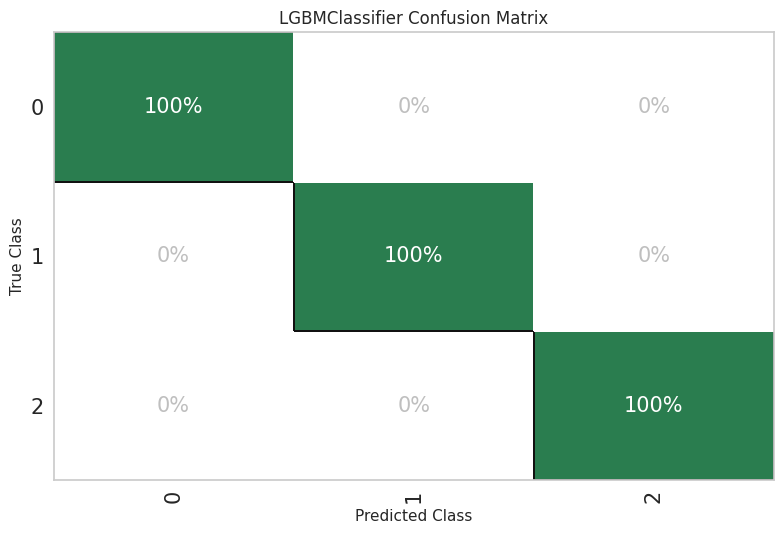

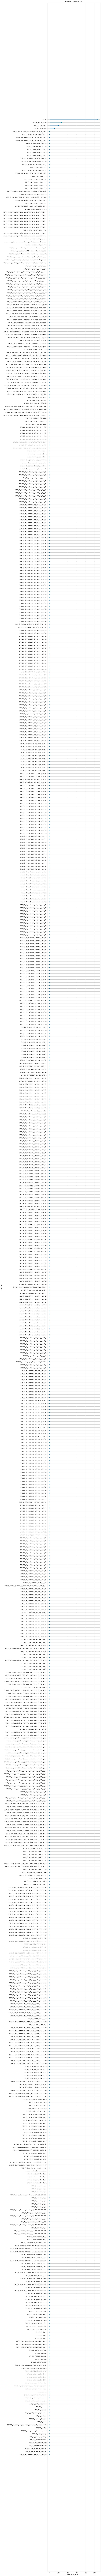

In [13]:
exp = ClassificationExperiment()
dataset_path = '../../data/'
# data = pd.read_csv(f'{dataset_path}combined_dataset.csv')
data = merged_df
data.replace([np.inf, -np.inf], np.nan, inplace=True)
# s = setup(data, target = 'signal', categorical_features=['coin'], session_id = 123, use_gpu=True)
s = setup(data, target = 'signal', session_id = 123, use_gpu=True)
model = create_model(LGBMClassifier())
validation_scores = pull()
accuracy_mean = validation_scores['Accuracy']['Mean']

# save pipeline
model_name = 'combined_model_tsfresh'
save_model(model, f'../../models/{model_name}-{accuracy_mean}')
print(f'{model_name} model saved. accuracy_mean={accuracy_mean}')
plot_model(model, plot = 'confusion_matrix', plot_kwargs = {'percent': True})
plot_model(model, plot = 'feature_all')


In [ ]:
from pycaret.classification import load_model, predict_model
import pandas as pd

data = pd.read_csv('../../data/combined_dataset.csv')
s = setup(data, target = 'signal', session_id = 123, use_gpu=True)

# Load trained Pipeline
model_name = 'combined_model_tsfresh'
model = load_model(f'../../models/{model_name}')
plot_model(model, plot = 'confusion_matrix', plot_kwargs = {'percent': True})
# plot_model(model, plot = 'feature_all')

In [14]:
%matplotlib inline
import matplotlib.pylab as plt

from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import pandas as pd
import numpy as np


from tsfresh.examples.har_dataset import download_har_dataset, load_har_dataset, load_har_classes

# fetch dataset from uci
download_har_dataset()

In [15]:
df = load_har_dataset()
df.head()

0         1         2         3         4         5         6    \
0  0.000181  0.010139  0.009276  0.005066  0.010810  0.004045  0.004757   
1  0.001094  0.004550  0.002879  0.002247  0.003305  0.002416  0.001619   
2  0.003531  0.002285 -0.000420 -0.003738 -0.006706 -0.003148  0.000733   
3 -0.001772 -0.001311  0.000388  0.000408 -0.000355  0.000998  0.001109   
4  0.000087 -0.000272  0.001022  0.003126  0.002284  0.000885  0.001933   

        7         8         9    ...       118       119       120       121  \
0  0.006214  0.003307  0.007572  ...  0.001412 -0.001509  0.000060  0.000435   
1  0.000981  0.000009 -0.000363  ... -0.000104 -0.000141  0.001333  0.001541   
2  0.000668  0.002162 -0.000946  ...  0.000661  0.001853 -0.000268 -0.000394   
3 -0.003149 -0.008882 -0.010483  ...  0.000458  0.002103  0.001358  0.000820   
4  0.002270  0.002247  0.002175  ...  0.002529  0.003518 -0.000248 -0.002761   

        122       123       124       125       126       127  
0 -0.000819  0.000228 -0.000300 -0.001147 -0.000222  0.001576  
1  0.001077 -0.000736 -0.003767 -0.004646 -0.002941 -0.001599  
2 -0.000279 -0.000316  0.000144  0.001246  0.003117  0.002178  
3 -0.000212 -0.001915 -0.001631 -0.000867 -0.001172 -0.000028  
4  0.000252  0.003752  0.001626 -0.000698 -0.001223 -0.003328  

[5 rows x 128 columns]

In [17]:
y = load_har_classes()
y.head()

0    5
1    5
2    5
3    5
4    5
Name: 0, dtype: int64

In [18]:
df["id"] = df.index
df = df.melt(id_vars="id", var_name="time").sort_values(["id", "time"]).reset_index(drop=True)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

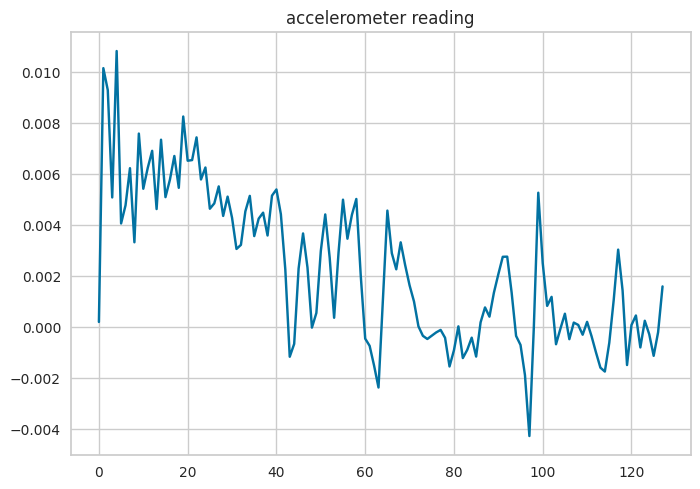

In [19]:
plt.title('accelerometer reading')
plt.plot(df[df["id"] == 0].set_index("time").value)
plt.show()

In [26]:
print(len(df.columns))
print(df.head())
df.to_csv(f'{dataset_path}tsfresh_data_df.csv', index=False)
# only use the first 500 ids to speed up the processing
X = extract_features(df[df["id"] < 500], column_id="id", column_sort="time", impute_function=impute)


3
   id time     value
0   0    0  0.000181
1   0    1  0.010139
2   0    2  0.009276
3   0    3  0.005066
4   0    4  0.010810


Feature Extraction: 100%|██████████| 50/50 [00:02<00:00, 17.51it/s]


In [22]:
len(X.columns)


783

In [29]:
len(y)

7352